In [1]:
import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.notebook import trange, tqdm, tqdm_notebook
from joblib import Parallel, delayed
import re
import h5py
import tifffile as tiff
import napari

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = (Path().cwd().parents[0] / 'data').absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figures').absolute()

df_meta_path = data_dir /'tissue'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [5]:
df_imgs = df_imgs[df_imgs.FOV == '20X']

# Per region quantification

In [6]:
import pickle 
from sklearn.neighbors import NearestNeighbors
from skimage import measure 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def create_PPI_df(mask, PPI_loc, name):
    PPI_subset = PPI_loc[(PPI_loc[:, 0] < mask.shape[0]) & (PPI_loc[:, 1] < mask.shape[1])]
    PPI_labels = mask[PPI_subset[:,0], PPI_subset[:,1]]

    columns_name = ['Region', 'x', 'y']
    
    df = pd.DataFrame(np.hstack([PPI_labels[:,np.newaxis], PPI_subset]), 
                      columns=columns_name)
    df['PPI'] = name
    df_region = pd.DataFrame(measure.regionprops_table(mask, properties=('label', 'area')))
    return df, df_region

In [7]:
mask_dir =data_dir /'tissue'/'20x'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('_')[0]
    
    if 'lymp.tif' in path :
        masks_path[name]['lymp'] = mask_dir / path
    elif 'tumor.tif' in path :
        masks_path[name]['tumor'] = mask_dir / path   
    else:
        pass

In [8]:
# Read PPI
PPI_save_path =  data_dir / 'tissue' / 'PPI'
df_PPIs = []
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read tumor and lymph
    mask_path = masks_path[row[1]]['lymp']
    mask_lymp = skimage.io.imread(mask_path)
    mask_path = masks_path[row[1]]['tumor']
    mask_tumor = skimage.io.imread(mask_path)
    mask_lymp_dims = {"x_size": mask_lymp.shape[0], "y_size":mask_lymp.shape[1]}
    mask_tumor_dims = {"x_size": mask_tumor.shape[0], "y_size":mask_tumor.shape[1]}

    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

    dfs_PPI_cyto = []
    
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        df_PPI, df_region = create_PPI_df(mask_lymp, PPI_loc, k)
        df_PPI = df_PPI[df_PPI.Region != 0]
        df_PPI = df_PPI.groupby(['Region', 'PPI'], as_index=False).size()
        df_PPI = df_PPI.merge(df_region, left_on='Region', right_on='label', how='left')
        df_PPI['Condition'] = row[1]
        df_PPI['Type'] = 'Lymphocyte Region'
        df_PPIs.append(df_PPI)
        
        df_PPI, df_region = create_PPI_df(mask_tumor, PPI_loc, k)
        df_PPI = df_PPI[df_PPI.Region != 0]
        df_PPI = df_PPI.groupby(['Region', 'PPI'], as_index=False).size()
        df_PPI = df_PPI.merge(df_region, left_on='Region', right_on='label', how='left')
        df_PPI['Condition'] = row[1]
        df_PPI['Type'] = 'Tumor Region'

        df_PPIs.append(df_PPI)


In [9]:
df_PPI = pd.concat(df_PPIs)
df_PPI['Count per Area'] = df_PPI['size'].div(df_PPI['area']) / (0.3774**2)

In [10]:
df_PPI['Condition'] = df_PPI['Condition'].apply(lambda x: {'577-1197': 'Responder', '577-1210': 'Non responder'}.get(x,x)) 

In [11]:
df_PPI_lymphocyte = df_PPI[df_PPI.Type == 'Lymphocyte Region']
df_PPI_lymphocyte = (df_PPI_lymphocyte.pivot_table(values='Count per Area', columns='PPI', index=['Condition', 'Region'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition','Region'], value_name='Count per Area', var_name='PPI')
)

df_PPI_tumor = df_PPI[df_PPI.Type == 'Tumor Region']
df_PPI_tumor = (df_PPI_tumor.pivot_table(values='Count per Area', columns='PPI', index=['Condition', 'Region'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition','Region'], value_name='Count per Area', var_name='PPI')
)

In [12]:
from statannotations.Annotator import Annotator
import seaborn as sns

In [13]:
from statannotations.Annotator import Annotator
import seaborn as sns 

def plot(plotting, figsize=(10,8), y_title='Count PPI per cell'):
    c1, c2 = plotting['data'][plotting['hue']].unique()
    pairs = [((e, c1), (e, c2)) for e in plotting['data'][plotting['x']].unique()]

    with sns.plotting_context('talk', font_scale=1.5):
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.boxplot(**plotting, showfliers=False, ax=ax)
        ax = sns.swarmplot(**plotting, ax=ax, dodge=True, edgecolor='k', size=5,  linewidth=1)
        annot = Annotator(ax, pairs, **plotting)
        annot.configure(test='t-test_ind',  text_format='star', loc='outside', verbose=2)
        result = annot.apply_test().annotate()
        ax.set_ylabel(y_title, fontsize=40)
        plt.xticks(rotation=30, ha='right')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [19]:
df_PPI_lymphocyte = df_PPI_lymphocyte[df_PPI_lymphocyte['Count per Area'] < 0.15]

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 61.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 68.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E/CDK2_Non responder vs. Cyclin E/CDK2_Responder: t-test independent samples, P_val:2.748e-04 t=-4.180e+00
Cyclin D1/CDK4_Non responder vs. Cyclin D1/CDK4_Responder: t-test independent samples, P_val:1.421e-05 t=-5.327e+00
NF-Kb/p-P90rsk_Non responder vs. NF-Kb/p-P90rsk_Responder: t-test independent samples, P_val:2.293e-01 t=1.230e+00
Sox2/Oct4_Non responder vs. Sox2/Oct4_Responder: t-test independent samples, P_val:1.635e-01 t=-1.432e+00
TRAIL/DR5_Non responder vs. TRAIL/DR5_Responder: t-test independent samples, P_val:2.210e-04 t=-4.261e+00
p-ERK/c-MYC_Non responder vs. p-ERK/c-MYC_Responder: t-test independent samples, P_val:4.327e-03 t=-3.115e+00


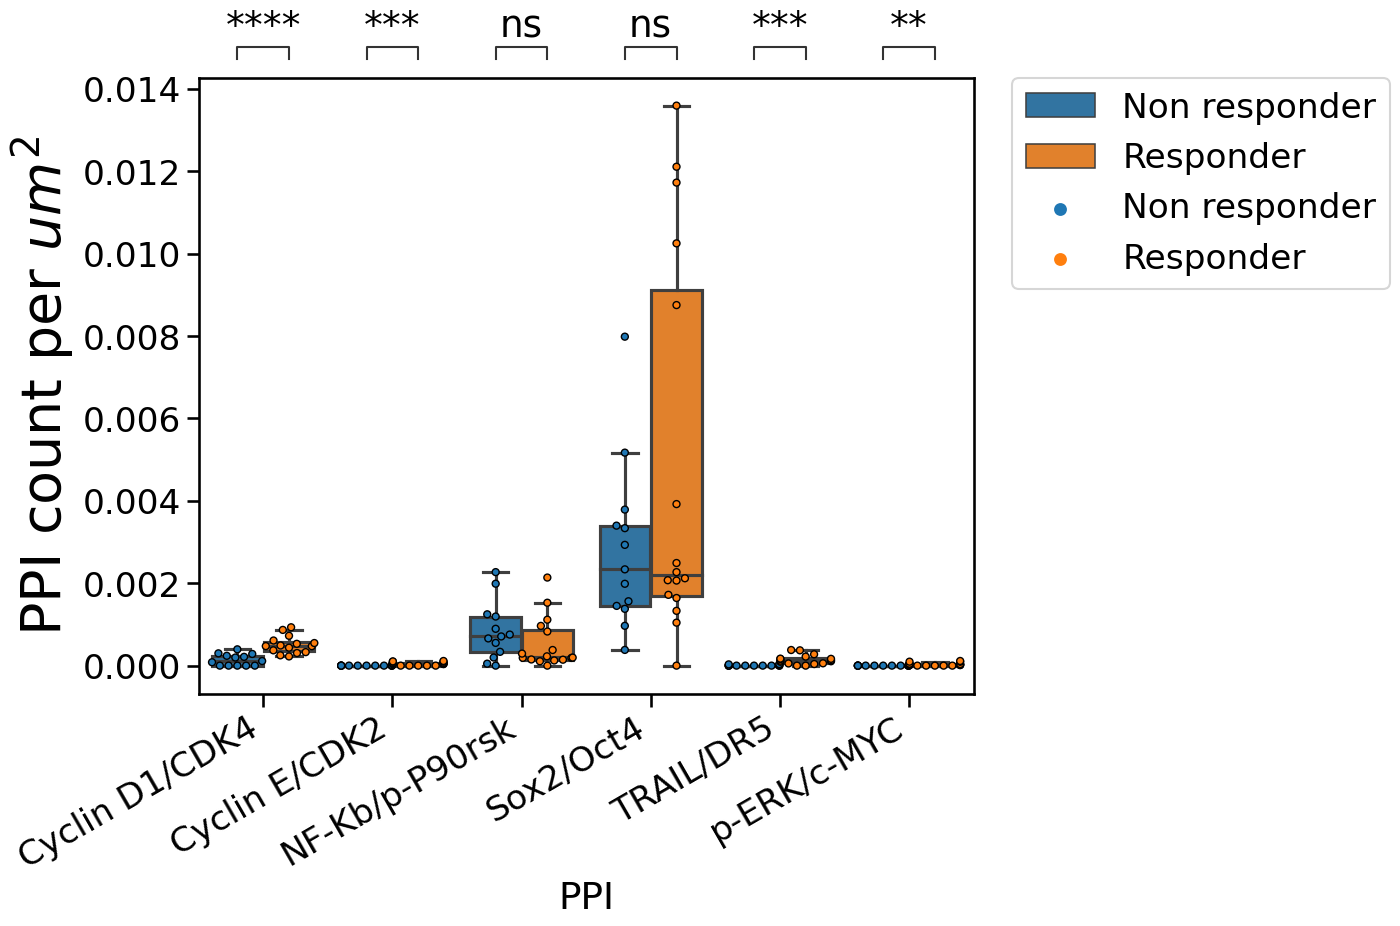

In [20]:
# Boxplot per cell
plotting = {
    "data": df_PPI_lymphocyte,
    "x": "PPI",
    "y": 'Count per Area',
    "hue": "Condition",
}

plot(plotting, y_title='PPI count per $um^2$')

In [15]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 73.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\thu71\AppData\Local\anaconda3\envs\scanpy\Lib\site-packages\seaborn\categorical.py:1296: UserWarning: 68.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cyclin E/CDK2_Non responder vs. Cyclin E/CDK2_Responder: t-test independent samples, P_val:3.783e-06 t=-5.450e+00
Cyclin D1/CDK4_Non responder vs. Cyclin D1/CDK4_Responder: t-test independent samples, P_val:4.075e-01 t=-8.382e-01
NF-Kb/p-P90rsk_Non responder vs. NF-Kb/p-P90rsk_Responder: t-test independent samples, P_val:1.977e-03 t=3.337e+00
Sox2/Oct4_Non responder vs. Sox2/Oct4_Responder: t-test independent samples, P_val:4.359e-02 t=-2.092e+00
TRAIL/DR5_Non responder vs. TRAIL/DR5_Responder: t-test independent samples, P_val:1.120e-02 t=2.674e+00
p-ERK/c-MYC_Non responder vs. p-ERK/c-MYC_Responder: t-test independent samples, P_val:2.063e-08 t=-7.154e+00


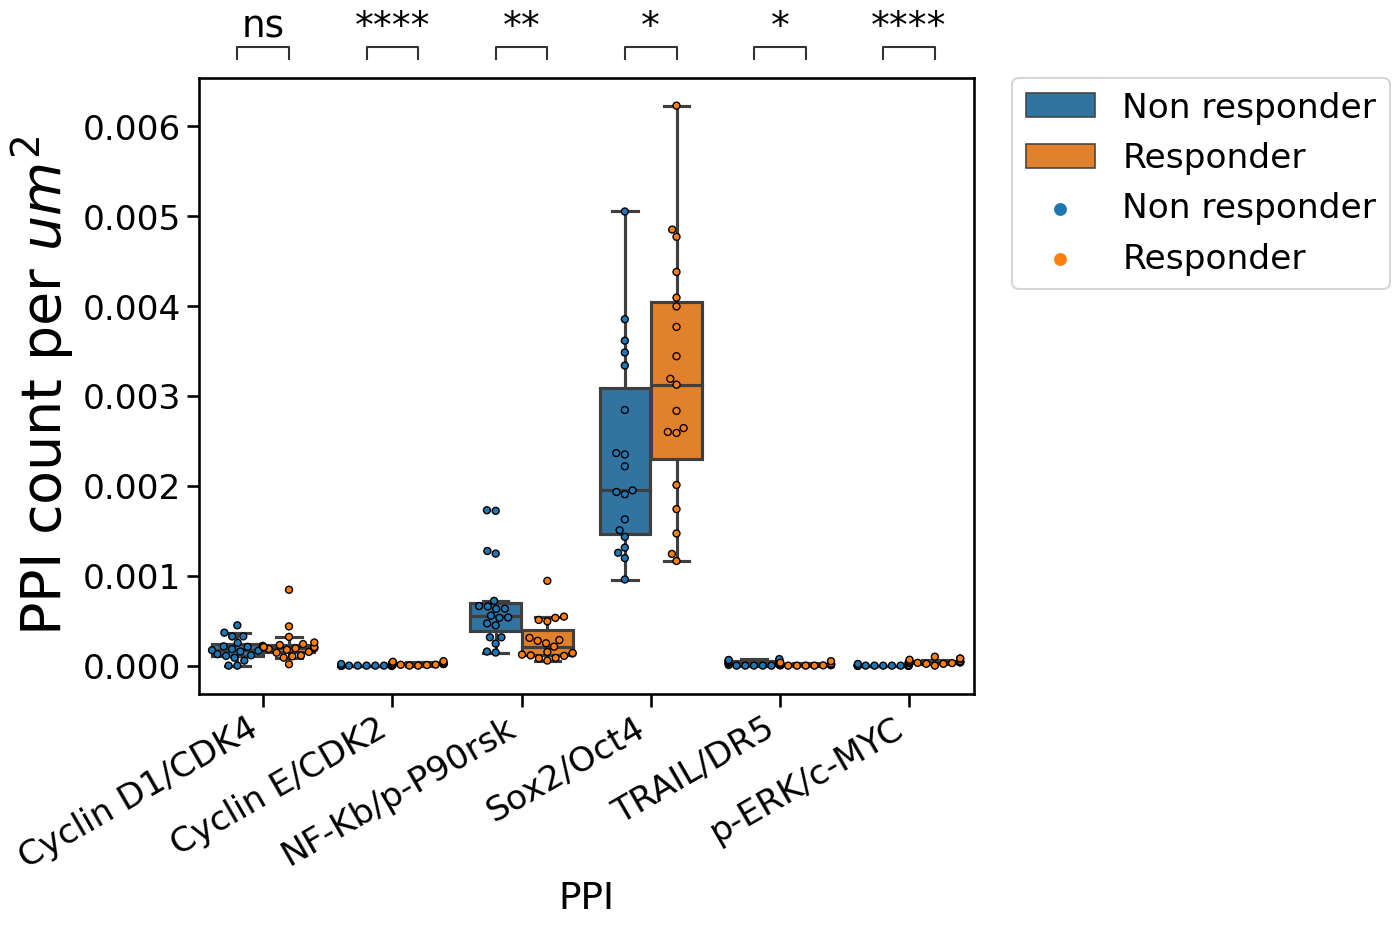

In [16]:
# Boxplot per cell
plotting = {
    "data": df_PPI_tumor,
    "x": "PPI",
    "y": 'Count per Area',
    "hue": "Condition",
}

plot(plotting, y_title='PPI count per $um^2$')

In [17]:
plotting['data'].groupby([plotting['hue'], plotting['x']])[plotting['y']].describe().to_clipboard()

# Plot visual example

In [226]:
import pickle 
from sklearn.neighbors import NearestNeighbors
from skimage import measure 
import vispy 
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

def get_loc_ppi(df, Condition, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [227]:
# HE ims
he_dir = data_dir / 'tissue' / 'HE_re_pyr'


In [228]:
# Create PPI dataframe
PPI_save_path =  data_dir / 'tissue' / 'PPI'
df_PPIs = []

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

    dfs_PPI_cyto = []
    
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        df_PPI = pd.DataFrame(PPI_loc, 
                      columns=['x', 'y'])
        df_PPI['PPI'] = k
        df_PPI['Condition'] = row[1]
        df_PPIs.append(df_PPI)

df_PPI = pd.concat(df_PPIs)
df_PPI.columns = [ 'row', 'column',  'PPI', 'Condition']
df_PPI.head()

,row,column,PPI,Condition
0,3613,39458,Sox2/Oct4,577-1197
1,4242,42427,Sox2/Oct4,577-1197
2,16372,26121,Sox2/Oct4,577-1197
3,5720,29833,Sox2/Oct4,577-1197
4,6568,17512,Sox2/Oct4,577-1197


In [92]:
mask_dir =data_dir /'tissue'/'20x'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('_')[0]
    
    if 'lymp.tif' in path :
        masks_path[name]['lymp'] = mask_dir / path
    elif 'tumor.tif' in path :
        masks_path[name]['tumor'] = mask_dir / path   
    else:
        pass

In [123]:
# Read HE image
HE_dir =data_dir /'tissue'/'HE_reg_pyr'

# Get list of PPI name
PPIs = df_PPI.PPI.unique()

[array(['Cyclin D1/CDK4', 'Cyclin E/CDK2', 'NF-Kb/p-P90rsk', 'Sox2/Oct4',
       'TRAIL/DR5', 'p-ERK/c-MYC'], dtype=object)]


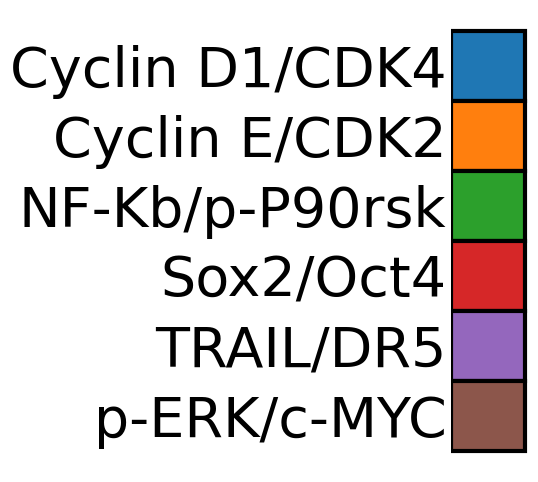

In [124]:
# Get colors
import palettable
from sklearn.preprocessing import OneHotEncoder

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df_PPI['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df_PPI['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_10.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [179]:
image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'PLA_scatter'

## 577-1197

In [180]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

name = '_'.join(row[1:3])
    
# Read tumor and lymph
mask_path = masks_path[row[0]]['lymp']
mask_lymp = skimage.io.imread(mask_path)
mask_path = masks_path[row[0]]['tumor']
mask_tumor = skimage.io.imread(mask_path)
mask_lymp_dims = {"x_size": mask_lymp.shape[0], "y_size":mask_lymp.shape[1]}
mask_tumor_dims = {"x_size": mask_tumor.shape[0], "y_size":mask_tumor.shape[1]}

# Read HE image
img = skimage.io.imread(HE_dir / f'{row[0]}_{row[1]}.ome.tif')

Condition                                             577-1197
FOV                                                        20X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 0, dtype: object


In [190]:
# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_lymp, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]

for item in df_region.itertuples():
    min_row = item[3]
    min_col = item[4]
    max_row = item[5]
    max_col = item[6]
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_lymp[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'magenta' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
          for PPI_name in PPIs]
    viewer = napari.view_image(img_he_region)
    label = viewer.add_labels(mask_region , color=color, opacity=0.9)
    label.contour = 20
    for i, point in enumerate(points):
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        points_layer = viewer.add_points(point, size=15)
        points_layer.face_color = colors_rgb_dict[PPIs[i]]/255

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:

In [192]:
# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_tumor, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]

for item in df_region.itertuples():
    min_row = item[3]
    min_col = item[4]
    max_row = item[5]
    max_col = item[6]
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_tumor[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'green' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
          for PPI_name in PPIs]
    viewer = napari.view_image(img_he_region)
    label = viewer.add_labels(mask_region , color=color, opacity=0.9)
    label.contour = 20
    for i, point in enumerate(points):
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        points_layer = viewer.add_points(point, size=15)
        points_layer.face_color = colors_rgb_dict[PPIs[i]]/255

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:3

## 577-1120

In [193]:
# Get images
index = 1
row = df_imgs.iloc[index]
print(row)
path = row.Path

name = '_'.join(row[1:3])
    
# Read tumor and lymph
mask_path = masks_path[row[0]]['lymp']
mask_lymp = skimage.io.imread(mask_path)
mask_path = masks_path[row[0]]['tumor']
mask_tumor = skimage.io.imread(mask_path)
mask_lymp_dims = {"x_size": mask_lymp.shape[0], "y_size":mask_lymp.shape[1]}
mask_tumor_dims = {"x_size": mask_tumor.shape[0], "y_size":mask_tumor.shape[1]}

# Read HE image
img = skimage.io.imread(HE_dir / f'{row[0]}_{row[1]}.ome.tif')

Condition                                             577-1210
FOV                                                        20X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 2, dtype: object


In [194]:
# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_lymp, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]

for item in df_region.itertuples():
    min_row = item[3]
    min_col = item[4]
    max_row = item[5]
    max_col = item[6]
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_lymp[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'magenta' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
          for PPI_name in PPIs]
    viewer = napari.view_image(img_he_region)
    label = viewer.add_labels(mask_region , color=color, opacity=0.9)
    label.contour = 20
    for i, point in enumerate(points):
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        points_layer = viewer.add_points(point, size=15)
        points_layer.face_color = colors_rgb_dict[PPIs[i]]/255

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3053479444.py:

In [195]:
# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_tumor, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]

for item in df_region.itertuples():
    min_row = item[3]
    min_col = item[4]
    max_row = item[5]
    max_col = item[6]
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_tumor[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'green' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
          for PPI_name in PPIs]
    viewer = napari.view_image(img_he_region)
    label = viewer.add_labels(mask_region , color=color, opacity=0.9)
    label.contour = 20
    for i, point in enumerate(points):
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        points_layer = viewer.add_points(point, size=15)
        points_layer.face_color = colors_rgb_dict[PPIs[i]]/255

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
    viewer.close()
    # Save image
    tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:32: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\355649114.py:3

# Spatial Viz Scoring

In [266]:
from numpy.lib.stride_tricks import as_strided

def get_node_patch(X, n):
    patches = X//n
    return patches

def tile_array(a, b0, b1):
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides 
    x = as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0)) # view a as larger 4D array
    return x.reshape(r*b0, c*b1)                      # create new 2D array

def patch_count(node_patch, n, shape):
    patch_matrix = np.zeros(tuple(d//n+1 for d in shape[:2]))
    for node in node_patch:
        i, j = node
        i = int(i)
        j = int(j)
        patch_matrix[i][j] += 1
    patch_matrix = patch_matrix
    return patch_matrix

[array(['Cyclin D1/CDK4', 'Cyclin E/CDK2', 'NF-Kb/p-P90rsk', 'Sox2/Oct4',
       'TRAIL/DR5', 'p-ERK/c-MYC'], dtype=object)]


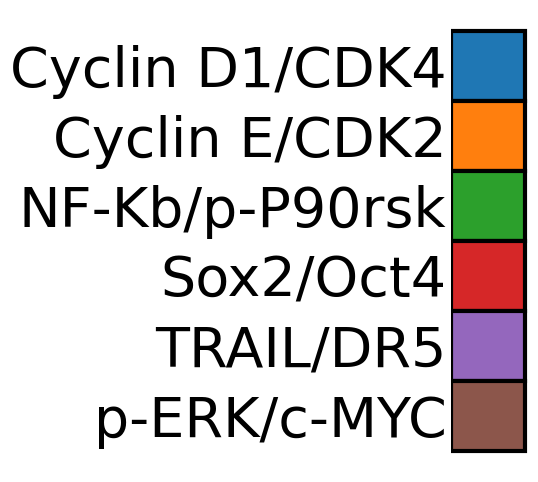

In [237]:
# Get colors
import palettable
from sklearn.preprocessing import OneHotEncoder

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df_PPI['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df_PPI['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_10.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [238]:
# Create PPI dataframe
PPI_save_path =  data_dir / 'tissue' / 'PPI'
df_PPIs = []

for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])
    
    # Read PPi
    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')

    dfs_PPI_cyto = []
    
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)
        df_PPI = pd.DataFrame(PPI_loc, 
                      columns=['x', 'y'])
        df_PPI['PPI'] = k
        df_PPI['Condition'] = row[1]
        df_PPIs.append(df_PPI)

df_PPI = pd.concat(df_PPIs)
df_PPI.columns = [ 'row', 'column',  'PPI', 'Condition']
df_PPI.head()

,row,column,PPI,Condition
0,3613,39458,Sox2/Oct4,577-1197
1,4242,42427,Sox2/Oct4,577-1197
2,16372,26121,Sox2/Oct4,577-1197
3,5720,29833,Sox2/Oct4,577-1197
4,6568,17512,Sox2/Oct4,577-1197


In [239]:
mask_dir =data_dir /'tissue'/'20x'

masks_path = defaultdict(dict) 
for path in os.listdir(mask_dir):
    name = path.split('_')[0]
    
    if 'lymp.tif' in path :
        masks_path[name]['lymp'] = mask_dir / path
    elif 'tumor.tif' in path :
        masks_path[name]['tumor'] = mask_dir / path   
    else:
        pass

In [240]:
# Read HE image
HE_dir =data_dir /'tissue'/'HE_reg_pyr'

# Get list of PPI name
PPIs = df_PPI.PPI.unique()

In [270]:
# Size of square patch to consider
n = 50

In [299]:
image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'tisse' / 'SpatialViz'
image_dir.mkdir(parents=True, exist_ok=True)

## 577-1197

In [300]:
# Get images
index = 0
row = df_imgs.iloc[index]
print(row)
path = row.Path

name = '_'.join(row[1:3])
    
# Read tumor and lymph
mask_path = masks_path[row[0]]['lymp']
mask_lymp = skimage.io.imread(mask_path)
mask_path = masks_path[row[0]]['tumor']
mask_tumor = skimage.io.imread(mask_path)
mask_lymp_dims = {"x_size": mask_lymp.shape[0], "y_size":mask_lymp.shape[1]}
mask_tumor_dims = {"x_size": mask_tumor.shape[0], "y_size":mask_tumor.shape[1]}

# Read HE image
img = skimage.io.imread(HE_dir / f'{row[0]}_{row[1]}.ome.tif')

Condition                                             577-1197
FOV                                                        20X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 0, dtype: object


In [301]:
offset = 0

In [303]:

# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_lymp, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]
for item in df_region.itertuples():
    min_row = item[3]-offset
    min_col = item[4]-offset
    max_row = item[5]+offset
    max_col = item[6]+offset
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_lymp[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'green' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
        for PPI_name in PPIs]
    
    for i in range(len(points)):
        point = points[i]
        node_patch = get_node_patch(point, n)
        count = patch_count(node_patch, n, img_he_region.shape)
        count_resized = tile_array(count, n,n )

        viewer = napari.view_image(img_he_region, opacity=0.7)
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        viewer.add_image(count_resized, blending='additive', colormap=red, opacity=0.9)
        label = viewer.add_labels(mask_region , color=color, opacity=0.9)
        label.contour = 20

        # Get screenshot
        screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
        viewer.close()
        # Save image
        tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_5408

In [304]:

# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_tumor, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]
for item in df_region.itertuples():
    min_row = item[3]-offset
    min_col = item[4]-offset
    max_row = item[5]+offset
    max_col = item[6]+offset
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_tumor[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'green' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
        for PPI_name in PPIs]
    
    for i in range(len(points)):
        point = points[i]
        node_patch = get_node_patch(point, n)
        count = patch_count(node_patch, n, img_he_region.shape)
        count_resized = tile_array(count, n,n )

        viewer = napari.view_image(img_he_region, opacity=0.7)
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        viewer.add_image(count_resized, blending='additive', colormap=red, opacity=0.9)
        label = viewer.add_labels(mask_region , color=color, opacity=0.9)
        label.contour = 20

        # Get screenshot
        screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
        viewer.close()
        # Save image
        tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_

## 577-1120

In [305]:
# Get images
index = 1
row = df_imgs.iloc[index]
print(row)
path = row.Path

name = '_'.join(row[1:3])
    
# Read tumor and lymph
mask_path = masks_path[row[0]]['lymp']
mask_lymp = skimage.io.imread(mask_path)
mask_path = masks_path[row[0]]['tumor']
mask_tumor = skimage.io.imread(mask_path)
mask_lymp_dims = {"x_size": mask_lymp.shape[0], "y_size":mask_lymp.shape[1]}
mask_tumor_dims = {"x_size": mask_tumor.shape[0], "y_size":mask_tumor.shape[1]}

# Read HE image
img = skimage.io.imread(HE_dir / f'{row[0]}_{row[1]}.ome.tif')

Condition                                             577-1210
FOV                                                        20X
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\tiss...
Name: 2, dtype: object


In [306]:
offset = 0

In [307]:

# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_lymp, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]
for item in df_region.itertuples():
    min_row = item[3]-offset
    min_col = item[4]-offset
    max_row = item[5]+offset
    max_col = item[6]+offset
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_lymp[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'green' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
        for PPI_name in PPIs]
    
    for i in range(len(points)):
        point = points[i]
        node_patch = get_node_patch(point, n)
        count = patch_count(node_patch, n, img_he_region.shape)
        count_resized = tile_array(count, n,n )

        viewer = napari.view_image(img_he_region, opacity=0.7)
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        viewer.add_image(count_resized, blending='additive', colormap=red, opacity=0.9)
        label = viewer.add_labels(mask_region , color=color, opacity=0.9)
        label.contour = 20

        # Get screenshot
        screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
        viewer.close()
        # Save image
        tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\4000182035.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_lymp_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_5408

In [308]:

# Plot lymphocyte region
df_region = pd.DataFrame(measure.regionprops_table(mask_tumor, properties=('label', 'area', 'bbox')))
df_region.columns = ['Region', 'Area', 'min_row', 'min_col', 'max_row', 'max_col']
df_region = df_region[df_region['Area'] > 10000]
for item in df_region.itertuples():
    min_row = item[3]-offset
    min_col = item[4]-offset
    max_row = item[5]+offset
    max_col = item[6]+offset
    
    # Get HE region
    img_he_region = img[min_row: max_row, min_col:max_col]
    mask_region = mask_tumor[min_row: max_row, min_col:max_col]
    mask_id = np.unique(mask_region)
    color = {i: 'green' for i in mask_id if i != 0}

    points = [get_loc_ppi(df_PPI, row.Condition, min_col, min_row, max_col, max_row, PPI_name) 
        for PPI_name in PPIs]
    
    for i in range(len(points)):
        point = points[i]
        node_patch = get_node_patch(point, n)
        count = patch_count(node_patch, n, img_he_region.shape)
        count_resized = tile_array(count, n,n )

        viewer = napari.view_image(img_he_region, opacity=0.7)
        red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
        viewer.add_image(count_resized, blending='additive', colormap=red, opacity=0.9)
        label = viewer.add_labels(mask_region , color=color, opacity=0.9)
        label.contour = 20

        # Get screenshot
        screenshot = viewer.screenshot(size=np.array(mask_region.shape)*2)
        viewer.close()
        # Save image
        tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))

C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_54080\3445304805.py:36: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'{row.Condition}_tumor_{item[0]}_{i}.tif', removeBorders(screenshot))
C:\Users\thu71\AppData\Local\Temp\ipykernel_